# **Kornia**
## **Open Source Differentiable Computer Vision Library**

<img src="assets/kornia_logo.png" width=340>

[Kornia](https://kornia.readthedocs.io) это  библиотека дифференцируемых алгоритмов Компьютерного зрения с открытым исходным кодом. Содержит различные алгоритмы аугментации данных, функций потерь и метрик, а также имплементацию многих алгоритмов из openCV (но в отличие от последнего, все они дифференцируемы). Базируется на PyTorch.
<br>


**Сравнение схожих функций в Kornia и OpenCV**

[kornia.geometry.transform.warp_perspective](https://kornia.readthedocs.io/en/latest/geometry.transform.html#kornia.geometry.transform.warp_perspective) vs [cv2.warpPerspective](https://docs.opencv.org/4.5.3/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87)

<br>

**Примеры**

[Пример 1. Регрессия матрицы гомографии при помощи Градиентного спуска](https://github.com/kornia/kornia/tree/master/examples/homography_regression)

<u> Пример2. Проекция шаблона поля </u>

In [35]:
import json
import numpy as np
import cv2
import torch
import kornia
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]


def load_field_mask(path, field_size, inter=None):
    field_mask = cv2.imread(path, cv2.IMREAD_COLOR)

    if field_mask.shape[0] != field_size[1] or field_mask.shape[1] != field_size[0]:
        if inter is None:
            inter = cv2.INTER_AREA if field_mask.shape[1] > field_size[0] else cv2.INTER_CUBIC
        field_mask = cv2.resize(field_mask, field_size, interpolation=inter)

    return field_mask


class Warper:
    def __init__(self, size, cuda=True):
        self.warper = kornia.HomographyWarper(size[1], size[0], mode='nearest', normalized_coordinates=True)
        self.device = torch.device('cuda' if cuda and torch.cuda.is_available() else 'cpu')

    def warp(self, theta, proj):
        proj = torch.from_numpy(proj).type(torch.DoubleTensor).permute(2, 0, 1).unsqueeze(0)
        theta = torch.from_numpy(theta).unsqueeze(0)
        proj = proj.to(self.device)
        theta = theta.to(self.device)
        proj = self.warper(proj, theta)[0]
        proj = proj.permute(1, 2, 0).cpu().numpy()

        return proj
    
    
def show(img, title='', bgr2rgb=True):
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    if bgr2rgb:
        plt.imshow(img[...,::-1])
    else:
        plt.imshow(img)
    plt.show()
    
    
def overlay(img1, img2, alpha=0.3):
    m = cv2.inRange(img2, (0, 0, 0), (0, 0, 0))
    m = cv2.merge([m, m, m])
    overlaid = (img1 & m) + img2 * alpha + (img1 & (255 - m)) * (1 - alpha)

    return np.ascontiguousarray(overlaid.astype('uint8'))

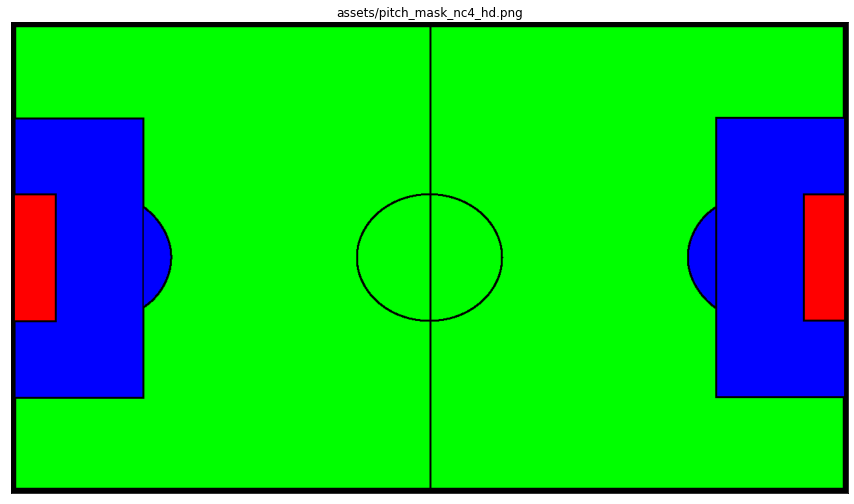

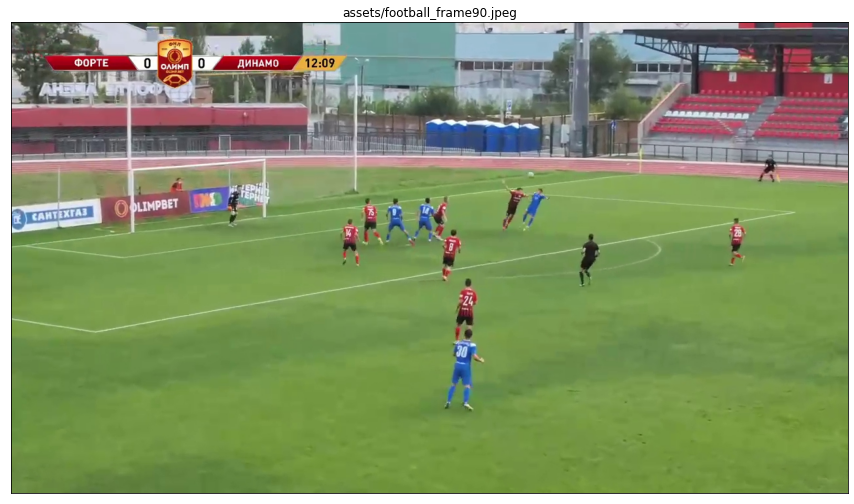

[[ 3.06466722  1.04429007 -9.96912861]
 [-3.21627212 22.30028915  0.92389941]
 [-0.24131542 12.38095379 13.46983719]]


In [37]:
# Warper:
warper = Warper(size=(1280,720), cuda=False)

# Load field mask:
mask_path = 'assets/pitch_mask_nc4_hd.png'
field_mask = load_field_mask(mask_path, (1280,720), inter=cv2.INTER_NEAREST)

# Load image:
img_path = 'assets/football_frame90.jpeg'
img = cv2.imread(img_path, 1)

# Load homography:
homo_path = 'assets/football_frame90_homo.json'
with open(homo_path, 'r') as f:
    homo = json.load(f)
theta = np.array(homo['theta_f2c'])
    
    
show(field_mask, title=mask_path)
show(img, title=img_path)
print (theta)

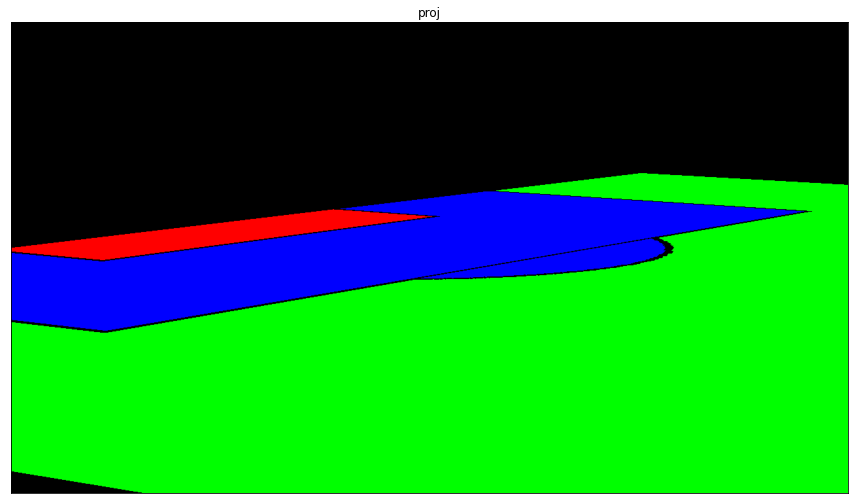

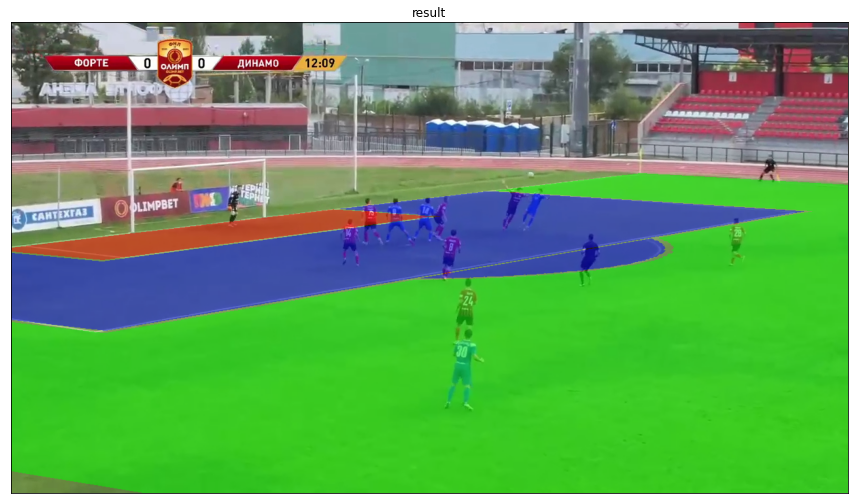

In [38]:
field_proj = warper.warp(theta, field_mask)
show(field_proj.astype(int), title='proj')

result = overlay(img, field_proj, alpha=0.5)
show(result, title='result')